In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import zipfile
# flag to decide if run everything or just visualize results
run_all_flag = False

In [2]:
import freyberg_setup
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR
freyberg_setup.setup_pest_kr()


if not run_all_flag:
    shutil.copy2('sweep.zip',os.path.join(working_dir,'sweep.zip'))
    with zipfile.ZipFile(os.path.join(working_dir,'sweep.zip')) as inzip:
        inzip.extractall(working_dir)

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following 

## First read in the PST file and find what are the starting values for K and R

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1


In [4]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.parameter_data.loc['rch_0','partrans']= 'log'
inpst.parameter_data.loc['rch_0','parval1']= 8.0E-1
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.0
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name))

In [5]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

run():./pestpp freyberg_kr.pst


In [6]:
inpst.phi_components

{'calflux': 0.0,
 'calhead': 2521.032937997162,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

## We can import a function to explore a range of K and R values to make a response surface

In [7]:
import response_surface as resurf

## First we should write out the control file with new bounds to bracket where values will be explored

## `rch_0` already spans the bounds we want, but `hk` is too wide

In [8]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = inpst.parameter_data
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12

inpst.write(os.path.join(working_dir,pst_name))

In [9]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.0,12.0,hk,1.0,0.0,1


## Run the `run_respsurf` function to calculate the response surface

In [10]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

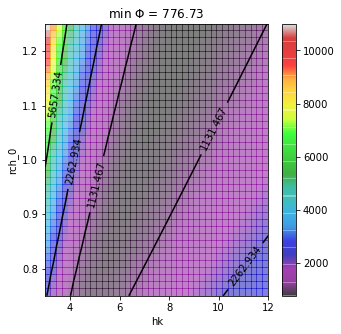

In [11]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

In [12]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name))

In [13]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

run():./pestpp freyberg_kr.pst


### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [14]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [15]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,9717.130505,-8534.049364
hk,-8534.049364,7608.864465


In [16]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.00000,-0.99249
hk,-0.99249,1.00000


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation in the group called `calflux`

We'll read in the PST file, change just that one value and write out a new PST file.

In [17]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [18]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.0,12.0,hk,1.0,0.0,1


In [19]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.parameter_data.loc['hk','parval1']= 12.0

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=10
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [20]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.0,12.0,hk,1.0,0.0,1


In [21]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r1.pst


In [22]:
inpst.phi_components

{'calflux': 71836202.2556554,
 'calhead': 2521.032937997162,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [23]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

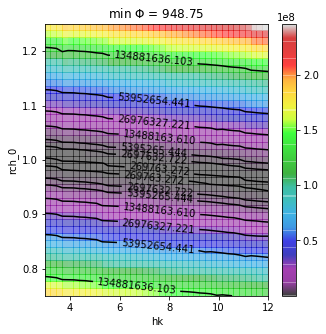

In [24]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'));

In [25]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [26]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r1.pst


### We can look at the correlation again

In [27]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r1.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [28]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r1.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,1.038275e+10,7.269534e+08
hk,7.269534e+08,5.090684e+07


In [29]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,0.999913
hk,0.999913,1.000000


In [30]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,rch_0,hk
flx_river_l_19700102,-10189.574242,-713.437000
cr03c10_19700102,5.141142,-4.845712
cr03c16_19700102,0.519940,-0.383235
cr04c09_19700102,6.074210,-5.734974
cr10c02_19700102,11.964366,-11.497914
cr14c11_19700102,2.285442,-1.467828
cr16c17_19700102,0.875689,-0.693493
cr22c11_19700102,3.130235,-2.268819
cr23c16_19700102,0.537595,-0.465825
cr25c05_19700102,9.053495,-7.821134


## OK - that was bonkers. Maybe a little less weight?

In [31]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.001
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [32]:
inpst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.0,12.0,hk,1.0,0.0,1


In [33]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r2.pst


In [34]:
inpst.phi_components

{'calflux': 0.7183620225565539,
 'calhead': 2521.032937997162,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [35]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'))

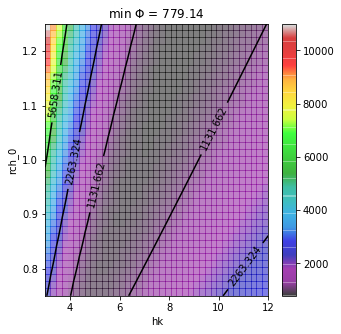

In [36]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'));

In [37]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [38]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r2.pst


## Let's check out correlation again

In [39]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r2.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [40]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r2.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,9820.957929,-8526.779745
hk,-8526.779745,7609.373458


In [41]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.986356
hk,-0.986356,1.000000


## Can we find a happy medium? Perhaps if we balance the components of the objective function

In [42]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.05
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [43]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r3.pst


In [44]:
inpst.phi_components

{'calflux': 1795.9050563913854,
 'calhead': 2521.032937997162,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [45]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'))

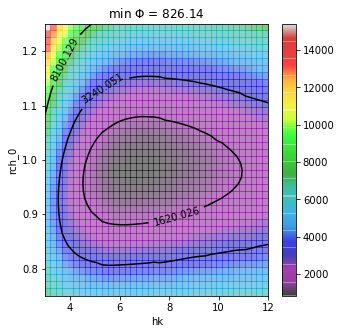

In [46]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'));

In [47]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 7
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.0
inpst.parameter_data.loc['rch_0', 'parlbnd'] = 0.6


inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [48]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r3.pst


In [49]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r3.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,1,1,7


In [50]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r3.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,433949.813888,-12947.799649
hk,-12947.799649,22249.186706


In [51]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.131771
hk,-0.131771,1.000000
